필요한 패키지를 로딩중입니다: rvest

Warning message:
"패키지 'rvest'는 R 버전 4.1.3에서 작성되었습니다"
필요한 패키지를 로딩중입니다: tidyverse

Warning message:
"패키지 'tidyverse'는 R 버전 4.1.3에서 작성되었습니다"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

Warning message:
"패키지 'ggplot2'는 R 버전 4.1.3에서 작성되었습니다"
Warning message:
"패키지 'tibble'는 R 버전 4.1.3에서 작성되었습니다"
Warning message:
"패키지 'tidyr'는 R 버전 4.1.3에서 작성되었습니다"
Warning message:
"패키지 'readr'는 R 버전 4.1.3에서 작성되었습니다"
Warning message:
"패키지 'purrr'는 R 버전 4.1.3에서 작성되었습니다"
Warning message:
"패키지 'dplyr'는 R 버전 4.1.3에서 작성되었습니다"
Warning message:
"패키지 'stringr'는 R 버전 4.1.3에서 작성되었습니다"
Warning message:
"패키지 'forcats'는 R 버전 4.1.3에서 작성되었습니다"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter()  

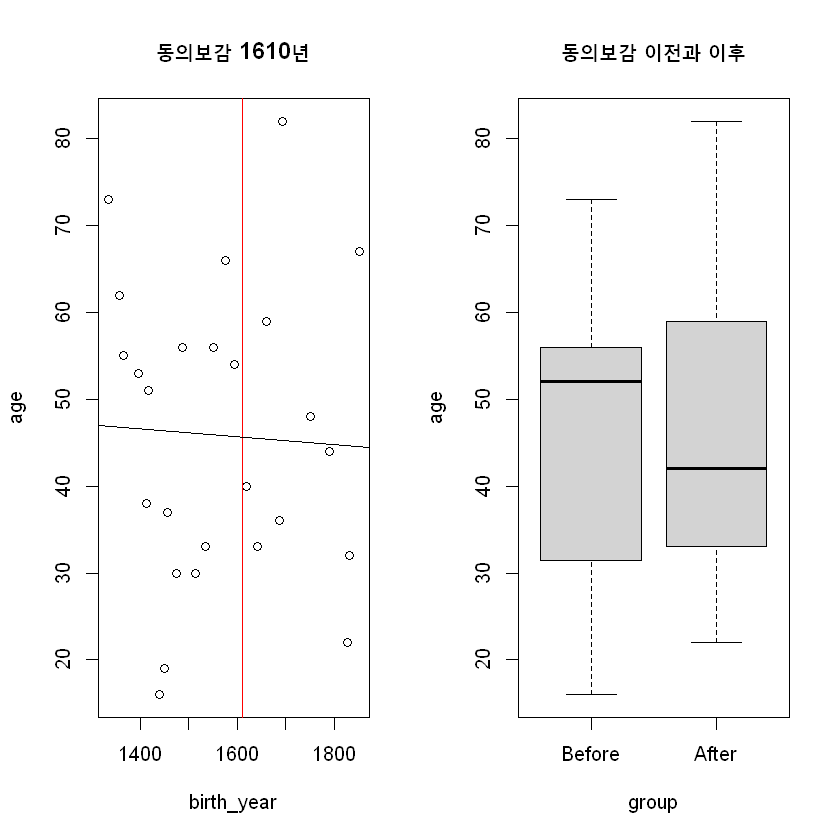

In [1]:
# sta : final
# des : avcl, imp speed, r41

# 필요한 라이브러리를 호출합니다. 존재하지 않으면 설치합니다.
if (!require(rvest)) install.packages('rvest')
library(rvest)

if (!require(tidyverse)) install.packages('tidyverse')
library(tidyverse)

get_required_info = function(rows, order){
    clean_table = rows[order] %>% # 한글자씩 쪼갠다.
        strsplit(split = '') %>%
        unlist() %>%
        str_replace('[^가-힣0-9]', 'N')  %>% # (한글, 숫자)가 아닌 문자는 불필요하므로 N으로 치환한다.
        paste(collapse = '') %>% # 모든 문자를 합친 다음 N을 기준으로 다시 나눈다.
        strsplit('N') %>%
        unlist()

    order_index = grep('^제.{1,}대$', clean_table)
    order = clean_table[order_index]
    
    name_index = grep('^.{1,2}[조|종|군]$', clean_table)[1]
    name = clean_table[name_index]

    years_index = grep('^.{1,}년$', clean_table)
    years <- # 순서대로 출생, 사망, 즉위, 퇴위
        clean_table[years_index] %>%
        substr(1, 4)

    grave_index = grep('^.{1,3}[릉|묘]$', clean_table)
    grave = clean_table[grave_index]
    
    return(c(order, name, years, grave))
}

target_url <- 'https://ko.wikipedia.org/wiki/%EC%A1%B0%EC%84%A0_%EA%B5%AD%EC%99%95'
unclean_table <- 
    read_html(target_url, encoding = 'UTF-8') %>%
    html_nodes('table[class=wikitable]') %>%
    html_nodes('tbody') %>%
    html_nodes('tr') %>%    
    html_text() 

# 필요로 하는 데이터는 모두 '제'로 시작한다.
# '제'로 시작하지 않는 데이터는 불필요하므로 제거한다.
requiredRows_index <- str_detect(unclean_table, '^제')
requiredRows <- unclean_table[requiredRows_index]

last_order = 26
kings_info <- vector('list', last_order)
for (i in 1:last_order){
    kings_info[[i]] = get_required_info(requiredRows, i)
}

kings_info = do.call('rbind', kings_info)
colnames(kings_info) = c('order', 'name', 'birth', 'death', 'king_start', 'king_end', 'grave')
write.table(kings_info, 'Joseon_king.txt', row.names=FALSE)

kings_info <- data.frame(kings_info)
kings_info[, c('birth', 'death')] =
    kings_info[, c('birth', 'death')] %>% 
    unlist() %>% 
    as.numeric()

kings_info = 
    kings_info %>%
    mutate(age = death - birth)

par(mfrow = c(1,2))
plot(kings_info$birth, kings_info$age,
     xlab = 'birth_year',
     ylab = 'age',
     main = '동의보감 1610년')

Donguibogam = 1610
abline(v = Donguibogam, col = 'red')
abline(lm(kings_info$age ~ kings_info$birth)) # 회귀선

# 상자그림
kings_info['class'] = 
    ifelse(kings_info['birth'] <= 1610, 'Before', 'After') %>%
    factor(levels = c('Before', 'After'))
            
boxplot(kings_info$age ~ kings_info$class,
        xlab = 'group',
        ylab = 'age',
        main = '동의보감 이전과 이후')